# Plotting Voronoi Diagrams over NYC

### Goals

* Explore **geopandas**: the primary Python package for spatial analysis
* Create a Voronoi diagram with data relevant to my life. They are striking!
* Contain the project to 2 days of work

### What's a Voronoi diagram?

A **[Voronoi diagram](https://en.wikipedia.org/wiki/Voronoi_diagram)** is a data visualization that partitions a plot around a set of points (or "seeds") into regions. Each region is the area closest to its seed. And regional boundaries are equidistant between the two closest seeds.

Voronoi diagrams are abundant in nature and in the history of science. In nature, think of the patches on a giraffe's skin.

In perhaps the first documented use of a double-blind test, John Snow used Voronoi diagrams to diagnose the source of cholera in London from a particular waste pump by mapping sewage drainage across London.

Voronoi diagrams are both beautiful and functional! Like this giraffe...

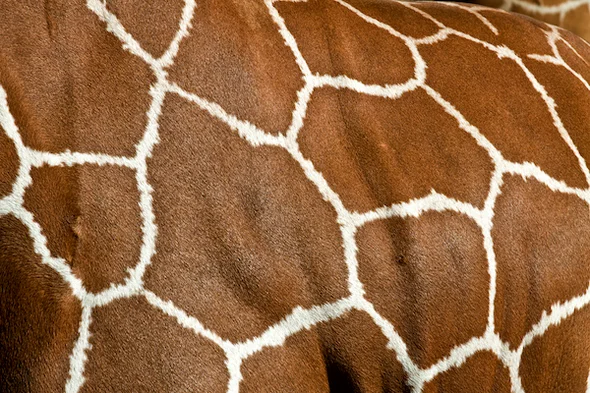

In [108]:
from IPython import display
display.Image("voronoi_giraffe.jpg")

## Data Acqusition

The source code for this analysis comes from the [NYC Open Data database](https://opendata.cityofnewyork.us/).

I use a map of NYC and geoDataFrames of **subway stations**, **public pools**, and **all pools** to make Voronoi diagrams. It's extremely hot here this summer, so I'm looking for ways to keep cool!

First, let's import the revelant packages:

In [109]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from geovoronoi import points_to_coords
from shapely.ops import unary_union
from scipy.spatial import Voronoi
from shapely.geometry import Polygon
from shapely import MultiPoint, Point

### Load GeoDataFrames

Loading in Shapefiles (.shp) for city limits, subway stations, public pools, and all pools.

Coordinates for public pools and all pools are initialized as polygons, I simplify them into geometric points by calculating the centroid of each polygon, which is easier for analysis. The EPSG value for New York City is 2236, which is the spatial reference coordinates needed to plot effectively.

Since I am sourcing the data from NYC Open Data, I am not evaluating whether any station or pool is actually inside the city limits. If that were a question for the source data, I would run more rigorous tests.

#### City Limits

In [110]:
# Load NYC borders
nyc = gpd.read_file("boundary.shp")
nyc.crs = "epsg:2236"
nyc = nyc.to_crs(epsg=2236)
nyc

,geometry
0,"MULTIPOLYGON (((-74.051 40.566, -74.050 40.566..."
1,"MULTIPOLYGON (((-73.897 40.796, -73.897 40.796..."
2,"MULTIPOLYGON (((-73.826 40.591, -73.826 40.590..."
3,"MULTIPOLYGON (((-74.011 40.684, -74.012 40.684..."
4,"MULTIPOLYGON (((-73.863 40.584, -73.864 40.584..."


#### Subway stations

In [111]:
# Load NYC subway stations
subways = gpd.read_file("nyc_subway_stations.shp")
subways.crs = "epsg:2236"
subways = subways.to_crs(epsg=2236)
subways.head()

,geometry
0,POINT (-73.991 40.730)
1,POINT (-74.000 40.719)
2,POINT (-73.984 40.762)
3,POINT (-73.975 40.681)
4,POINT (-73.895 40.665)


#### Public Pools

In [112]:
# Load NYC park pools (aka. public pools)
park_pools = gpd.read_file("park_pools.shp")
park_pools['geometry'] = park_pools['geometry'].centroid #transform polygon to point using centroid
park_pools.crs = "epsg:2236"
park_pools = park_pools.to_crs(epsg=2236)
park_pools.head()

,geometry
0,POINT (-74.004 40.673)
1,POINT (-73.889 40.804)
2,POINT (-73.940 40.702)
3,POINT (-73.955 40.796)
4,POINT (-73.784 40.702)


#### All Pools

In [113]:
# Create all in-ground NYC pools
pools = gpd.read_file("swimming_pools.shx")
pools['geometry'] = pools['geometry'].centroid
pools.crs = "epsg:2236"
pools = pools.to_crs(epsg=2236)
pools.head()

,geometry
0,POINT (-73.995 40.691)
1,POINT (-73.997 40.700)
2,POINT (-73.932 40.552)
3,POINT (-73.931 40.552)
4,POINT (-73.902 40.557)


### Map Alignment Checks

Before creating the Voronoi diagrams, I first check to ensure the city map and the coordinate points are aligned.

#### Subway Stations

(-74.28337047811618, -73.67222994890716, 40.475164048167294, 40.93650271594721)

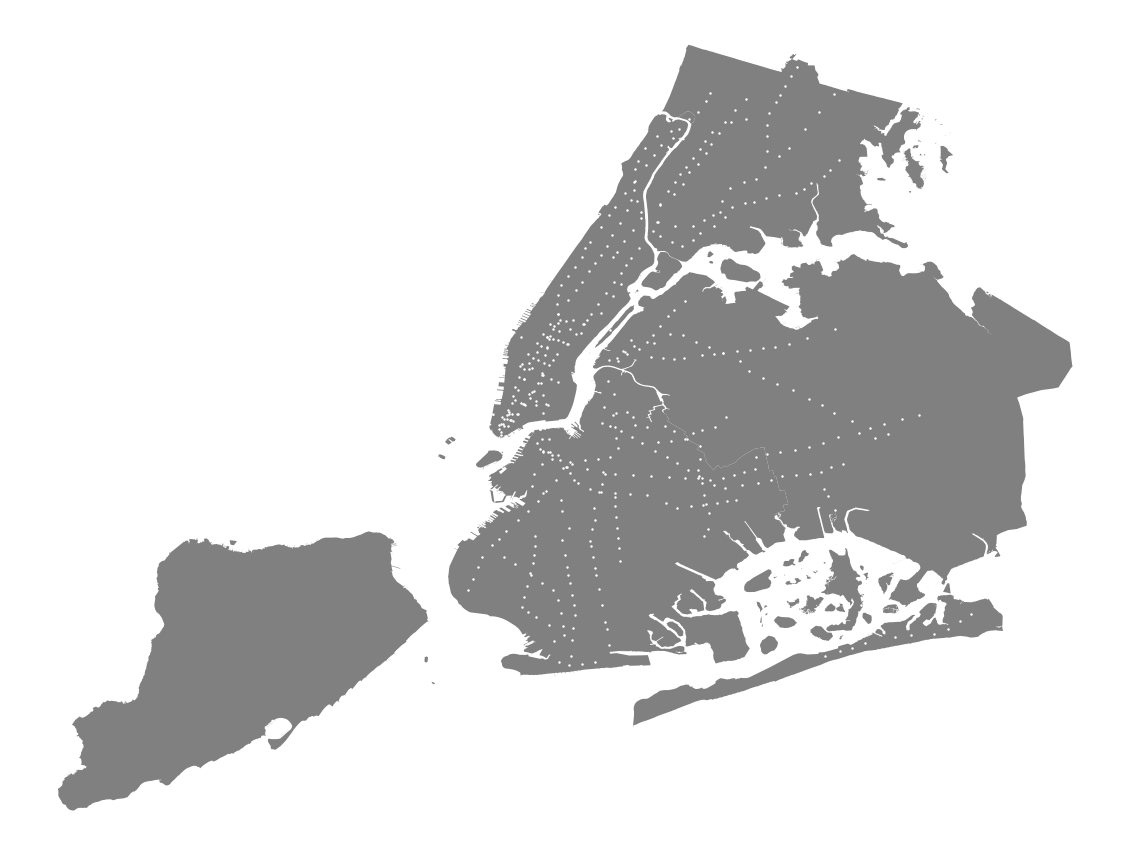

In [114]:
subways_proj = subways.to_crs(nyc.crs) # project points on NYC map

fig, ax = plt.subplots(figsize=(20, 20)) # set figsize

nyc.plot(ax=ax, color="grey") # set map background
subways_proj.plot(ax=ax, color="white", markersize=2) # set points on map
ax.axis("off") # remove axes

#### Public Pools

(-74.28337047811618, -73.67222994890716, 40.475164048167294, 40.93650271594721)

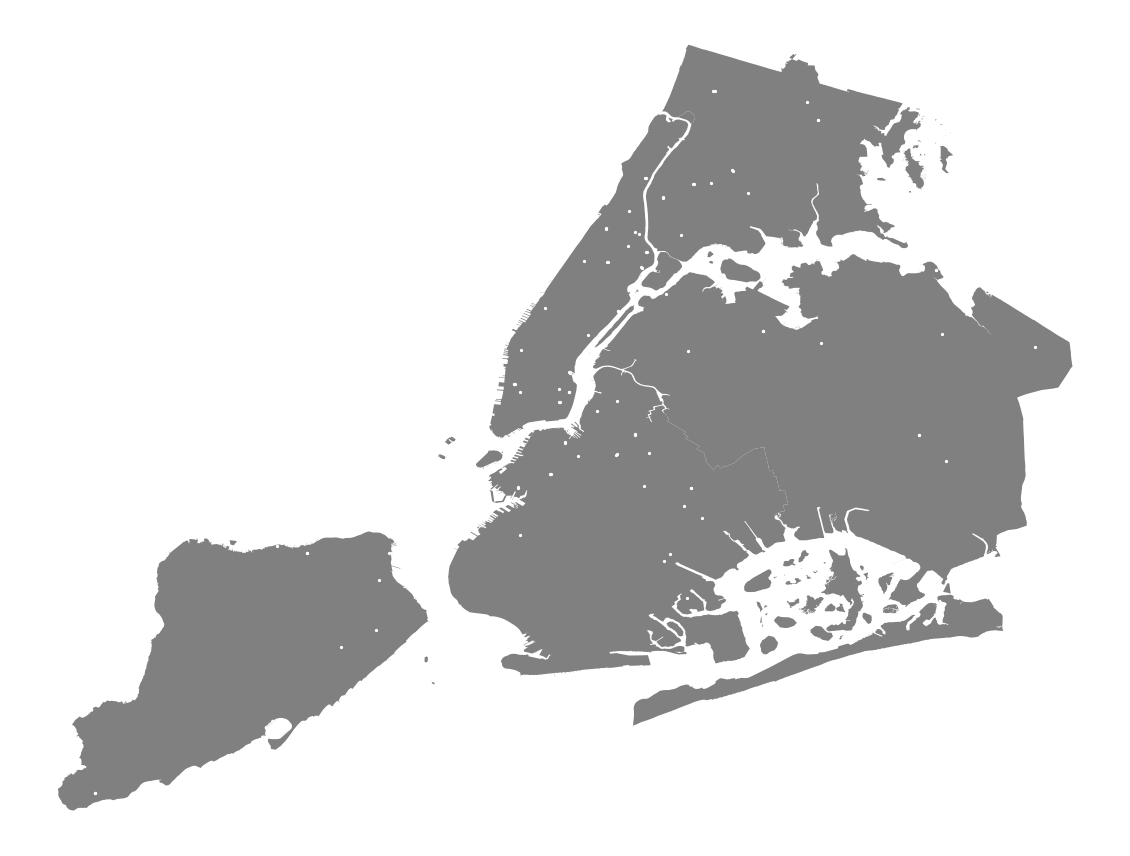

In [115]:
public_pools_gdf_proj = park_pools.to_crs(nyc.crs)

fig, ax = plt.subplots(figsize=(20, 20))

nyc.plot(ax=ax, color="grey")
public_pools_gdf_proj.plot(ax=ax, color="white", markersize=5)

ax.axis("off")

#### All Pools

(-74.28337047811618, -73.67222994890716, 40.475164048167294, 40.93650271594721)

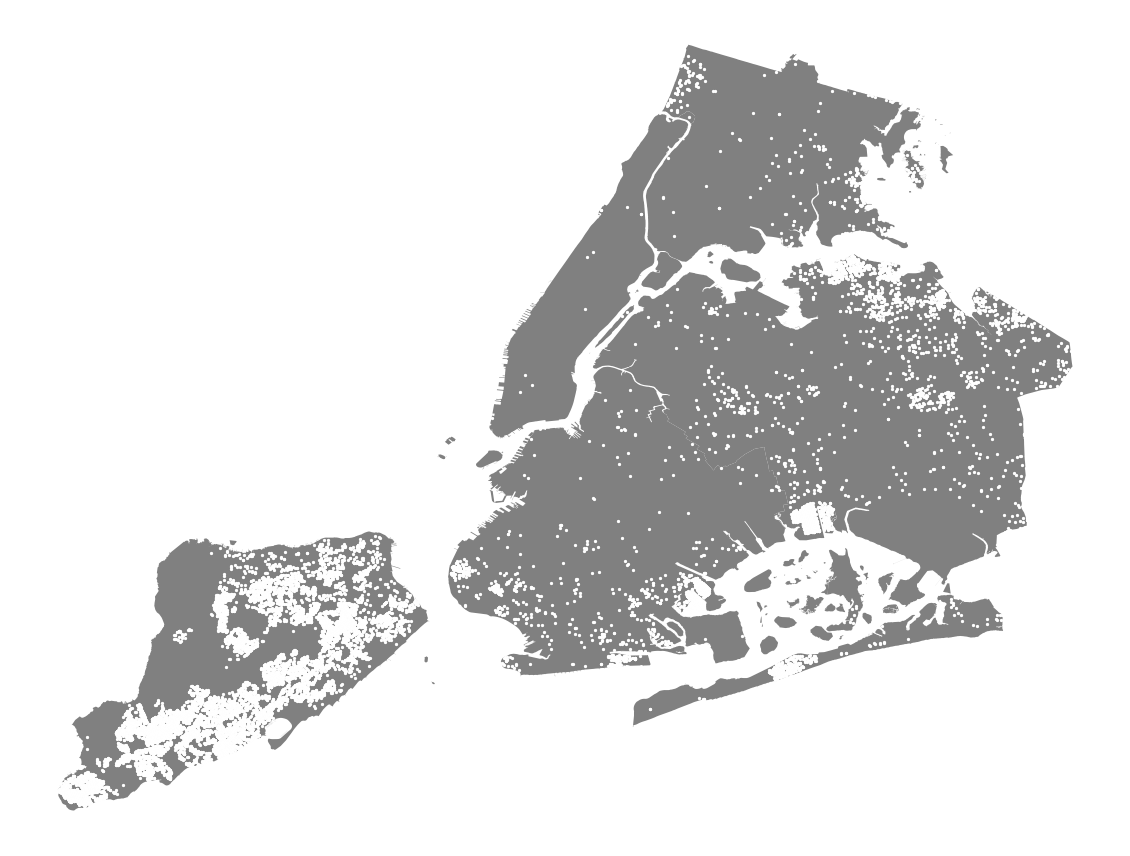

In [116]:
pools_gdf_proj = pools.to_crs(nyc.crs)

fig, ax = plt.subplots(figsize=(20, 20))

nyc.plot(ax=ax, color="grey")
pools_gdf_proj.plot(ax=ax, color="white", markersize=5)

ax.axis("off")

Looking good! We're ready to build Voronoi diagrams over these seeds on top of NYC.

### Voronoi Region Computation

I wont'get into the nitty-gritty math of making Voronoi diagrams in this notebook. However, [this article](https://towardsdatascience.com/the-fascinating-world-of-voronoi-diagrams-da8fc700fa1b) does a very good job at describing it in a digestible way, so I recommend reading it if interested further.

One reflection I had in this process is that I suspected there to be a full-service package to ingest, compute, and display Voronoi packages. Scipy has a few voronoi-specific functions, and there is an unmaintained (and now broken?) geovoronoi package. Just a surprise -- I suppose I landed on a popular-but-not-popular-enough dataviz technique? Or worse, it's super easy to make outside of Python somewhere?? Anyways, questions for another day...

In lieu of this magical package, I resort to making some functions on my own (read: scour stack overflow if someone has already asked the same question as me). Turns out, they have! [This thread](https://stackoverflow.com/questions/20515554/colorize-voronoi-diagram/20678647#20678647) provides the Voronoi cell computation function I use below. Thanks, fellow Voronoi fan!

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

### Voronoi Diagram Results

#### Subways Stations

In [118]:
# Fit map and points to readable formats for function
area_shape = unary_union(nyc.geometry)
coords = points_to_coords(subways_proj.geometry)
points = np.array(coords)
vor = Voronoi(points)

# Run function
regions, vertices = voronoi_finite_polygons_2d(vor)

(-74.28337047811618, -73.67222994890716, 40.474784436965365, 40.94447455118772)

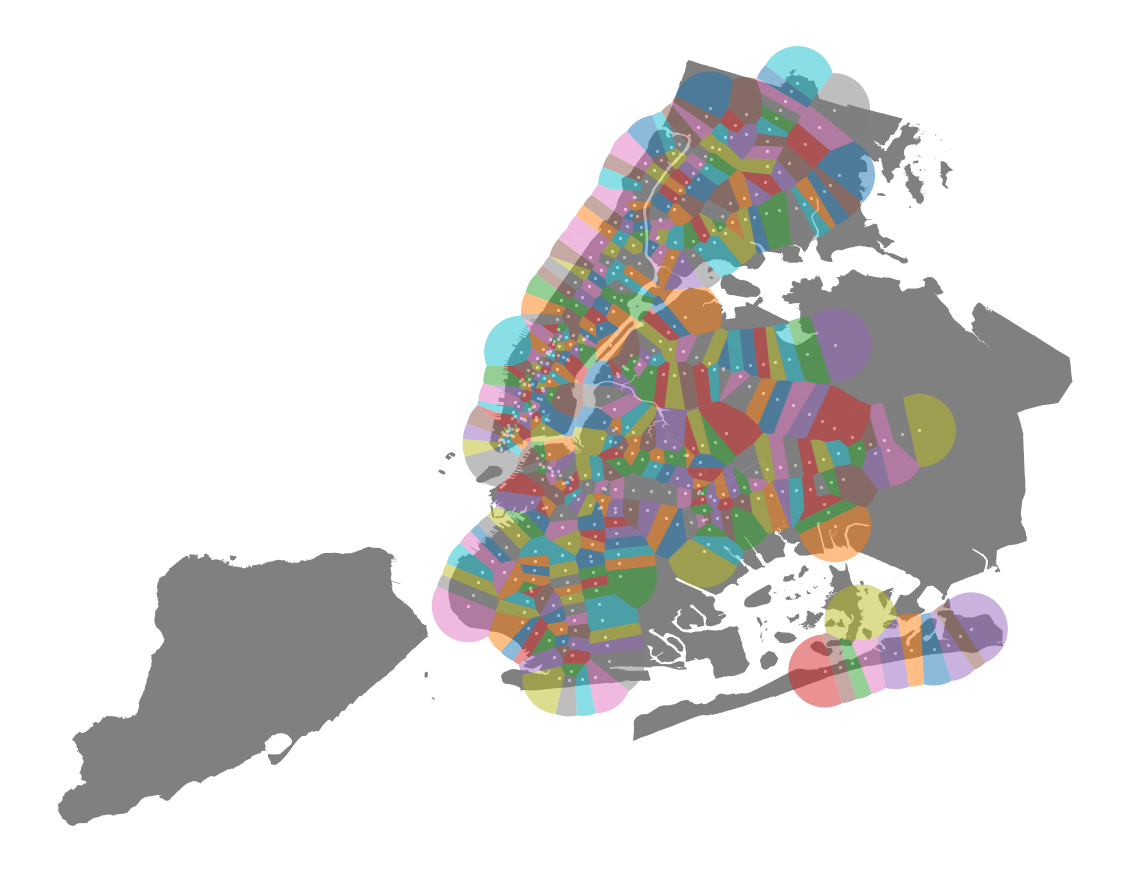

In [119]:
# Plot regions and vertices with Voronoi areas

pts = MultiPoint([Point(i) for i in coords])
mask = pts.buffer(0.02)
new_vertices = []

fig, ax = plt.subplots(figsize=(20, 20))

nyc.plot(ax=ax, color="grey")

for region in regions:
    polygon = vertices[region]
    shape = list(polygon.shape)
    shape[0] += 1
    p = Polygon(np.append(polygon, polygon[0]).reshape(*shape)).intersection(mask)
    poly = np.array(list(zip(p.boundary.coords.xy[0][:-1], p.boundary.coords.xy[1][:-1])))
    new_vertices.append(poly)
    ax.fill(*zip(*poly), alpha=0.5)
subways_proj.plot(ax=ax, color="white", markersize=5)

ax.axis('off')

My first impression is of the subway "dead zones" as each region is limited to 0.05 radians from the seed -- all of Staten Island and most of east Queens. 

Then, the uniformity of the subway lines leads to many thin rectangles (see upper Manhattan, the Bronx, and south Queens near JFK). Uniform regions would imply a singular line in that region. The most visually nonuniform regions are lower Manhattan and central Brooklyn. Nonuniform regions in this context may indicate criss-crossing subway lines and multiple directions to travel from that point.

#### Public Pools

In [120]:
park_pools_coords = points_to_coords(public_pools_gdf_proj.geometry)
park_pools_points = np.array(park_pools_coords)
vor = Voronoi(park_pools_points)

regions, vertices = voronoi_finite_polygons_2d(vor)

(-74.28337047811618, -73.67222994890716, 40.475164048167294, 40.93650271594721)

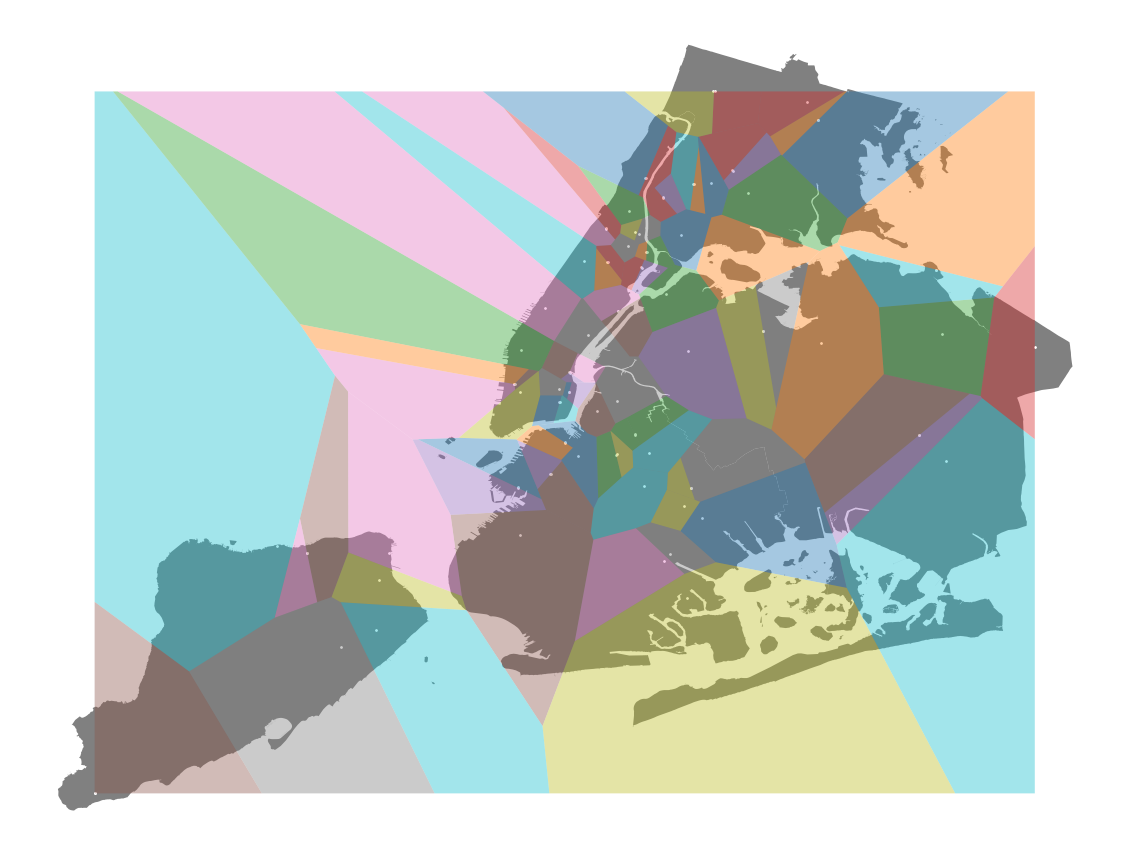

In [121]:
# Plot regions and vertices with Voronoi areas

pts = MultiPoint([Point(i) for i in park_pools_coords])
mask = pts.envelope
new_vertices = []

fig, ax = plt.subplots(figsize=(20, 20))

nyc.plot(ax=ax, color="grey")

for region in regions:
    polygon = vertices[region]
    shape = list(polygon.shape)
    shape[0] += 1
    p = Polygon(np.append(polygon, polygon[0]).reshape(*shape)).intersection(mask)
    poly = np.array(list(zip(p.boundary.coords.xy[0][:-1], p.boundary.coords.xy[1][:-1])))
    new_vertices.append(poly)
    ax.fill(*zip(*poly), alpha=0.4)
public_pools_gdf_proj.plot(ax=ax, color="white", markersize=3)

ax.axis('off')

Public pools in NYC are hard to come by across the board. Public pools are so sparse even, there are parts of west Brooklyn where the closest public pool is across the waterway in Staten Island (in pink). 

#### All Pools

In [122]:
# Fit coordinates to array for function
pools_coords = points_to_coords(pools_gdf_proj.geometry)
pools_points = np.array(pools_coords)
vor = Voronoi(pools_points)

# Run function
regions, vertices = voronoi_finite_polygons_2d(vor)

(-74.28337047811618, -73.67222994890716, 40.475164048167294, 40.93650271594721)

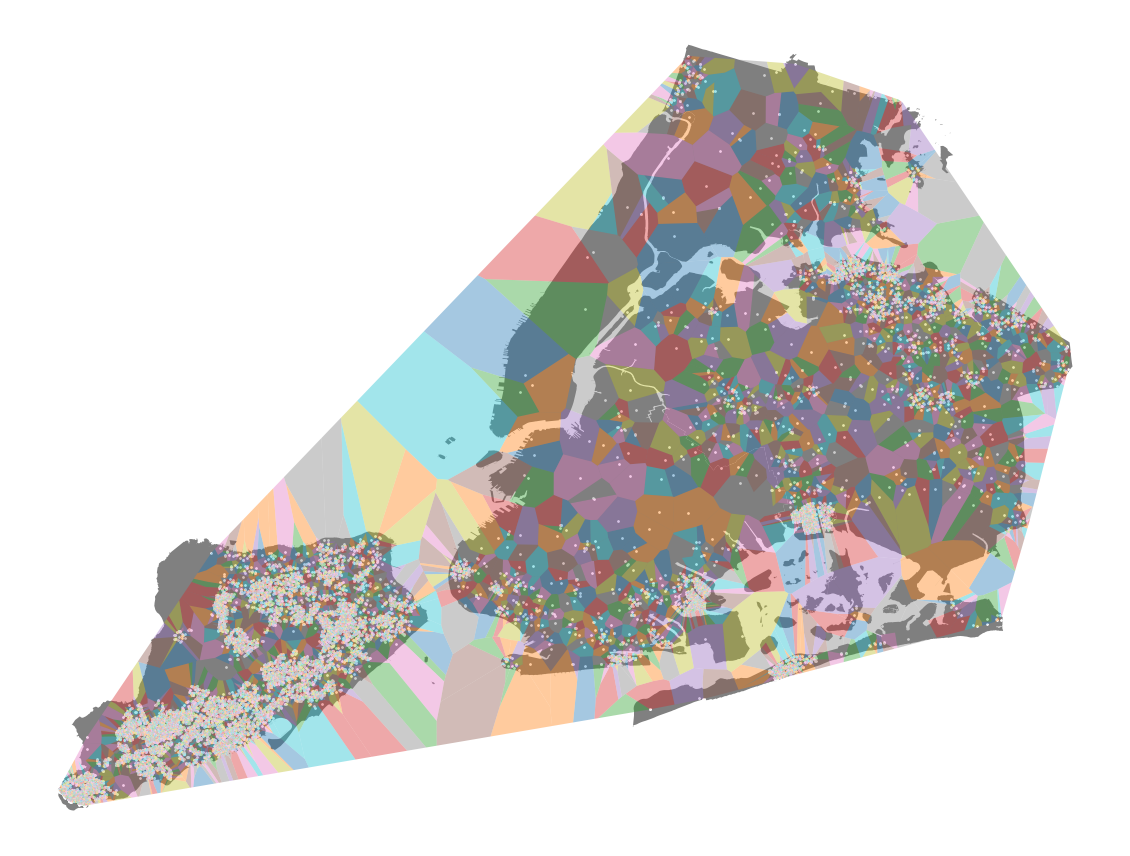

In [123]:
# Plot regions and vertices with Voronoi areas

pts = MultiPoint([Point(i) for i in pools_coords])
mask = pts.convex_hull
new_vertices = []

fig, ax = plt.subplots(figsize=(20, 20))

nyc.plot(ax=ax, color="grey")

for region in regions:
    polygon = vertices[region]
    shape = list(polygon.shape)
    shape[0] += 1
    p = Polygon(np.append(polygon, polygon[0]).reshape(*shape)).intersection(mask)
    poly = np.array(list(zip(p.boundary.coords.xy[0][:-1], p.boundary.coords.xy[1][:-1])))
    new_vertices.append(poly)
    ax.fill(*zip(*poly), alpha=0.4)
pools_gdf_proj.plot(ax=ax, color="white", markersize=3)

ax.axis('off')

Wow, there are a lot of private pools in Staten Island! Volume there and in north Queens may indicate more single-family homes that are more likely to have a pool, than, say, Manhattan where the volume of pools is very low. This also visually relates to the subway lines -- there are private pools where there aren't subways, and vice versa. Both these factors may proxy population density.

### Takeaways, Learnings, and Next Steps

#### Takeaways
* Subway "dead zones" affect all of Staten Island and lots of eastern Queens. It'd be interesting to see what percentage of the population are in those dead zones.
* Subways and private pools appear to be negatively correlated: where there are subways there aren't pools, and vice versa. Both factors likely proxy population density.
* If you're hot in the summer, make friends with someone in Staten Island or north Queens -- they likely have a pool :)

#### Analysis Learnings
* Coordinates in geopandas (esp the geometry properties) are extremely precise (and very satisfying) - I definitely want to use this more!
* I would have thought there'd be a full-service package to make Voronoi diagrams in Python. However, building parts of it myself got me much more in touch with what was happening under the hood.
* I wish I could clip the diagrams around the NYC city border. I didn't find a way to relate the two "layers" of the map and the Voronoi seeds and cells. That's gong to nag at me I'm sure when I look back on this!

#### Next Steps
* Use geopandas for an analytical project -- something like "how do urban heat islands (UHI) in cities influence health outcomes for its residents?"
* Use Voronoi diagrams to visualize k-nn model outputs. They are common vizualization tools for 1-NN models, where the diagram boundaries are the model's decision boundaries.
* If I make it back to do a v2 on this project, I'd make functions for the graphics instead of rewriting the code each time.